In [1]:
import pandas as pd
import pickle as pkl
import os
import numpy as np
import matplotlib.pyplot as plt
import json
import datetime as dt
from datetime import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

## Data prep

In [2]:
sit_path = r'C:\Users\mit\Dropbox (MIT)\wildfire_repo\sit_209\2020'
reports_df = pd.read_csv(f'{sit_path}/reports_small.csv')
reports_df['report_date'] = reports_df['REPORT_FROM_DATE'].apply(lambda x: datetime.strptime(x.split(" ")[0], "%m/%d/%Y"))
resources_df = pd.read_csv(f'{sit_path}/resources.csv')

In [4]:
path = 'data/processed'
inc_ids = os.listdir(path)

days = []
overshoots = []
raw_growths = []
inc_ids_2 = []

for inc_id in inc_ids:
    arr = np.load(f'{path}/{inc_id}/1/fire.npy')

    with open(f'{path}/{inc_id}/info.json', 'r') as f:
        info_dict = json.load(f)

    fire_days = np.dstack([np.load(f'{path}/{inc_id}/{day+1}/fire.npy') for day in range(info_dict['num_days'])])
    fire_days = fire_days > 0.1
    
    burned_history = [np.sum(np.max(fire_days[:, :, 0:day+1], axis=2)) for day in range(info_dict['num_days'])]


    for i in range(len(burned_history) - 5):
        x = np.arange(5)
        y = burned_history[i:i+5]

        if sum(y) > 0:
            m, b = np.polyfit(x, y, 1)
            pred = m * 5 + b
            new_burn_pred = pred - burned_history[i+4]
            new_burn_actual = burned_history[i+5] - burned_history[i+4]
            overshoot = (new_burn_actual - new_burn_pred) / burned_history[i+4] 
            days.append(i+5)
            inc_ids_2.append(inc_id)
            overshoots.append(overshoot)
            raw_growths.append(new_burn_actual)
            
kink_df = pd.DataFrame({'inc_id' : inc_ids_2, 'day' : days, 'overshoot' : overshoots, 'raw_growth' : raw_growths})

In [5]:
big_fires = kink_df.sort_values('raw_growth', ascending=False).drop_duplicates('inc_id')['inc_id'].iloc[:50]

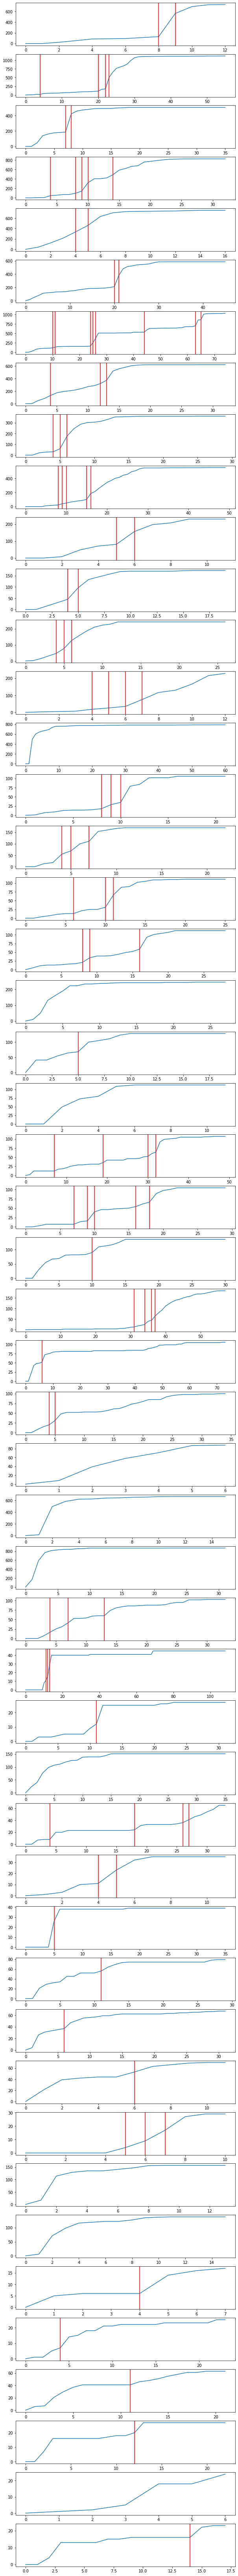

In [6]:
plt.rcParams['figure.figsize'] = (10, 120)
fig, ax = plt.subplots(len(big_fires))

for ix, inc_id in enumerate(big_fires):
    
    with open(f'{path}/{inc_id}/info.json', 'r') as f:
        info_dict = json.load(f)

    fire_days = np.dstack([np.load(f'{path}/{inc_id}/{day+1}/fire.npy') for day in range(info_dict['num_days'])])
    fire_days = fire_days > 0.1
    
    burned_history = [np.sum(np.max(fire_days[:, :, 0:day+1], axis=2)) for day in range(info_dict['num_days'])]

    ax[ix].plot(burned_history)
    
    inc_kink_df = kink_df[kink_df['inc_id'] == inc_id]
    for day in inc_kink_df[(inc_kink_df['overshoot'] > 0.1) & (inc_kink_df['raw_growth'] >= 5)]['day']:
        ax[ix].axvline(day-1, color='red')
        
plt.show()

In [8]:
cols = ['inc_id', 'on_fire', 'on_fire_back_1', 'on_fire_back_2', 'day', 'pct_contained', 'temp', 'humid', 'wind',
        'tree_frac', 'tree_density', 'shrub_frac', 'shrub_density', 'herb_frac', 'herb_density',
        'water_frac', 'slope', 'crew_members', 'dozers', 'engines', 'helicopters', 'next_on_fire', 'burned', 'new_burned', 
        'new_burned_plus_7', 'kink_next_7']

df = pd.DataFrame(columns=cols)

In [10]:
path = 'data/processed'
inc_ids = os.listdir(path)

count = 0
reports_count = 0
for inc_id in inc_ids:

    arr = np.load(f'{path}/{inc_id}/1/fire.npy')
    static_data = np.load(f'{path}/{inc_id}/static_data.npy')

    with open(f'{path}/{inc_id}/static_data.json', 'r') as f:
        lookup = json.load(f)

    with open(f'{path}/{inc_id}/info.json', 'r') as f:
        info_dict = json.load(f)

    fire_days = np.dstack([np.load(f'{path}/{inc_id}/{day+1}/fire.npy') for day in range(info_dict['num_days'])])
    fire_days = fire_days > 0.1
    
    inc_kink_df = kink_df[kink_df['inc_id'] == inc_id]
    kink_days = inc_kink_df[(inc_kink_df['overshoot'] > 0.1) & (inc_kink_df['raw_growth'] >= 5)]['day']

    for day in range(2, info_dict['num_days']-1):

        on_fire = fire_days[:, :, day]
        
        if np.sum(on_fire) > 0:
            
            on_fire_count = np.sum(on_fire)

            prior_on_fire = fire_days[:, :, day-1]
            prior_on_fire_count = np.sum(prior_on_fire)

            prior_2_on_fire = fire_days[:, :, day-2]
            prior_2_on_fire_count = np.sum(prior_2_on_fire)
            
            next_on_fire = fire_days[:, :, day+1]
            next_on_fire_count = np.sum(next_on_fire)

            burned = np.sum(np.max(fire_days[:, :, 0:day+1], axis=2))
            new_burned = np.sum(np.max(fire_days[:, :, 0:day+2], axis=2)) - burned
            new_burned_plus_7 = np.sum(np.max(fire_days[:, :, 0:day+8], axis=2)) - burned

            slope = static_data[:, :, lookup['slope']]
            slope = np.sum(slope * on_fire) / np.sum(on_fire)

            time = '12z'
            fxx = 'f00'

            weather_data = np.load(f'{path}/{inc_id}/{day+1}/weather_{time}_{fxx}.npy')

            with open(f'{path}/{inc_id}/{day+1}/weather_{time}.json', 'r') as f:
                weather_dict = json.load(f)

            weather = {}

            for key in weather_dict:
                weather[key] = np.mean(weather_data[:, :, weather_dict[key]])

            weather['wind'] = np.mean(np.sqrt(weather_data[:, :, weather_dict['UGRD:10 m']] ** 2 + 
                                              weather_data[:, :, weather_dict['VGRD:10 m']] ** 2))

            veg = static_data[:, :, lookup['evc']]

            tree = (veg > 109) & (veg < 200)
            tree_frac = np.sum(tree * on_fire) / on_fire_count
            tree_density = 0.0
            if tree_frac > 0:
                tree_density = np.sum(tree * on_fire * veg)  / np.sum(tree * on_fire) - 100

            shrub = (veg > 209) & (veg < 300)
            shrub_frac = np.sum(shrub * on_fire) / on_fire_count
            shrub_density = 0.0
            if shrub_frac > 0:
                shrub_density = np.sum(shrub * on_fire * veg)  / np.sum(shrub * on_fire) - 200

            herb = (veg > 309) & (veg < 400)
            herb_frac = np.sum(herb * on_fire) / on_fire_count
            herb_density = 0.0
            if herb_frac > 0:
                herb_density = np.sum(herb * on_fire * veg)  / np.sum(herb * on_fire) - 300

            water = (veg == 11)
            water_frac = np.sum(water * on_fire) / on_fire_count
            count += 1
            

            kink_next_7 = any((kink_days > day) & (kink_days <= day + 7))
            report_date = dt.datetime.strptime(info_dict['start_day'], "%Y%m%d") + dt.timedelta(days=day)
            
            # dataframe
            report_id = reports_df[(reports_df['INC_IDENTIFIER'] == int(inc_id)) & (reports_df['report_date'] == report_date)]
            
            if len(report_id) > 0:
                # id
                report_id = report_id['INC209R_IDENTIFIER'].iloc[0]
                
                day_resources = resources_df[resources_df['INC209R_IDENTIFIER'] == report_id].copy()
                if len(day_resources) > 0:
                    reports_count += 1
                    crew_members = day_resources[day_resources['resource'].apply(lambda x: 'CREW' in x.upper())]['RESOURCE_PERSONNEL'].sum()
                    dozers = day_resources[day_resources['resource'].apply(lambda x: 'DOZER' in x.upper())]['RESOURCE_QUANTITY'].sum()
                    engines = day_resources[day_resources['resource'].apply(lambda x: 'ENGINE' in x.upper())]['RESOURCE_QUANTITY'].sum()
                    helicopters = day_resources[day_resources['resource'].apply(lambda x: 'HELICOPTER' in x.upper())]['RESOURCE_QUANTITY'].sum()
                
                pct_contained = reports_df[reports_df['INC209R_IDENTIFIER'] == report_id]['PCT_CONTAINED_COMPLETED'].iloc[0]
                
                to_add = [inc_id, on_fire_count, prior_on_fire_count, prior_2_on_fire_count, day, pct_contained,
                          weather['TMP:2 m'], weather['SPFH:2 m'], weather['wind'],
                          tree_frac, tree_density, shrub_frac, shrub_density, herb_frac, herb_density,
                          water_frac, slope, crew_members, dozers, engines, helicopters, next_on_fire_count,
                         burned, new_burned, new_burned_plus_7, kink_next_7]
                
                df.loc[len(df)] = to_add

In [11]:
df['kink_next_7'].value_counts()

False    914
True     260
Name: kink_next_7, dtype: int64

In [12]:
df = df.astype(float)

In [18]:
for col in cols:
    df[f'log_{col}'] = np.log(1+df[col])

C:\Users\mit\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [95]:
cols_to_keep = cols[1:-9] 
cols_to_keep = [col for col in cols_to_keep if 'day' not in col]
# cols_to_keep = [col for col in cols_to_keep if 'on_fire' not in col]
logs = [col for col in cols_to_keep if col not in ['temp', 'humid', 'wind']]

formula = get_regression_formula(cols_to_keep, logs)
formula

'kink_next_7 ~ log_on_fire + log_on_fire_back_1 + log_on_fire_back_2 + log_pct_contained + temp + humid + wind + log_tree_frac + log_tree_density + log_shrub_frac + log_shrub_density + log_herb_frac + log_herb_density + log_water_frac + log_slope'

In [96]:
model = smf.logit(formula=formula, data=df)
result = model.fit(cov_type='HC3')
df['model_pred'] = result.predict()

Optimization terminated successfully.
         Current function value: 0.461511
         Iterations 7


Float64Index([11856938.0, 11837476.0, 11930517.0, 11881214.0, 11948237.0], dtype='float64')

In [113]:
longest_fires = df['inc_id'].value_counts().keys()[0:15]

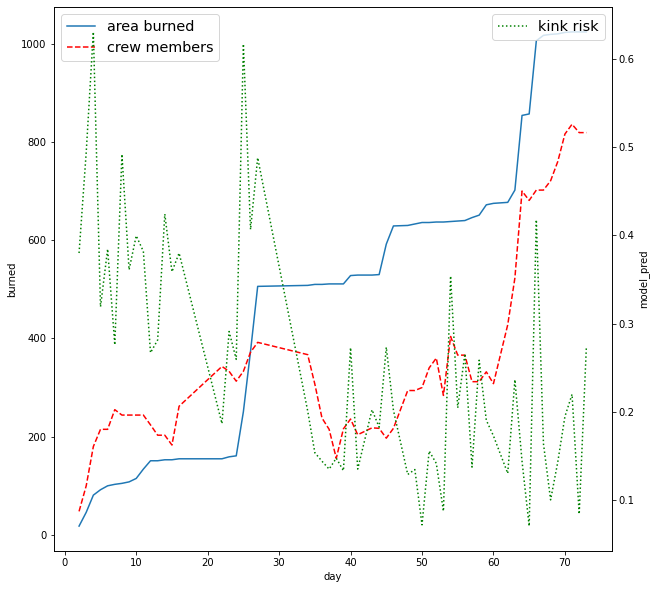

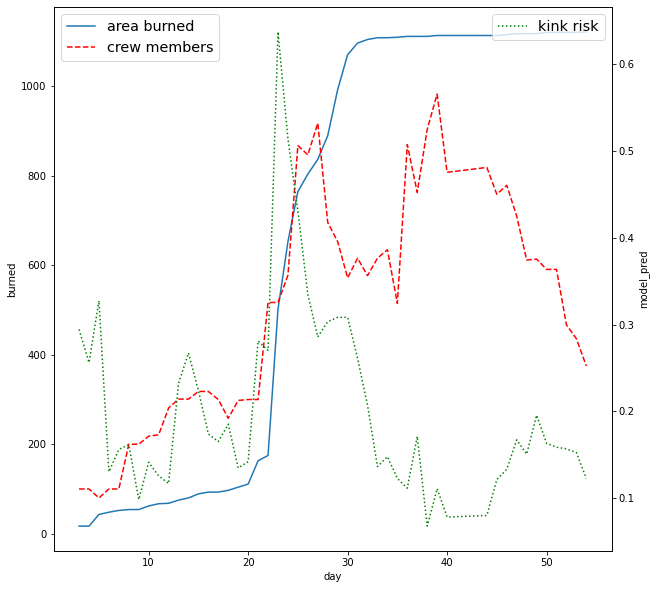

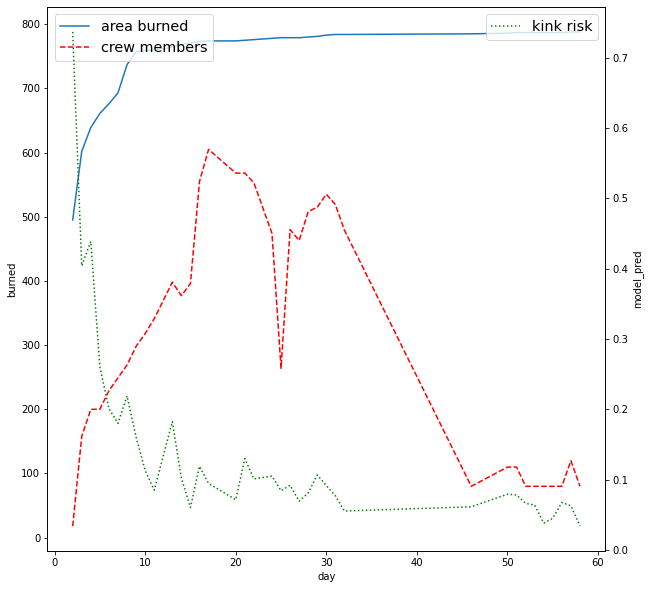

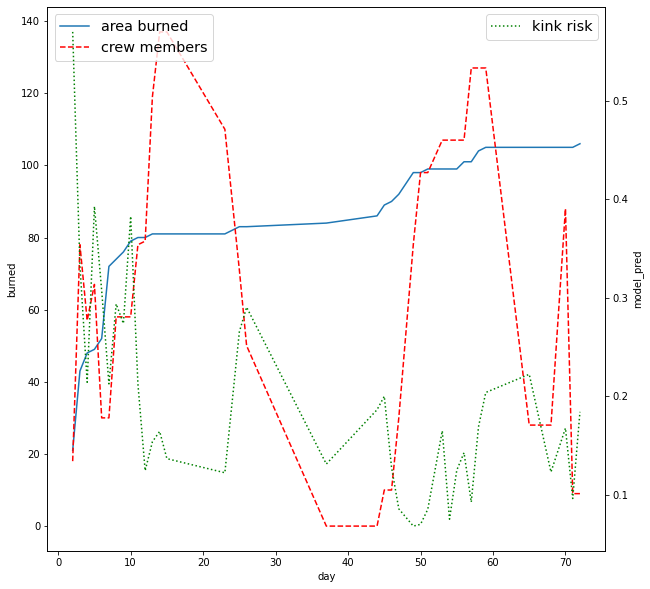

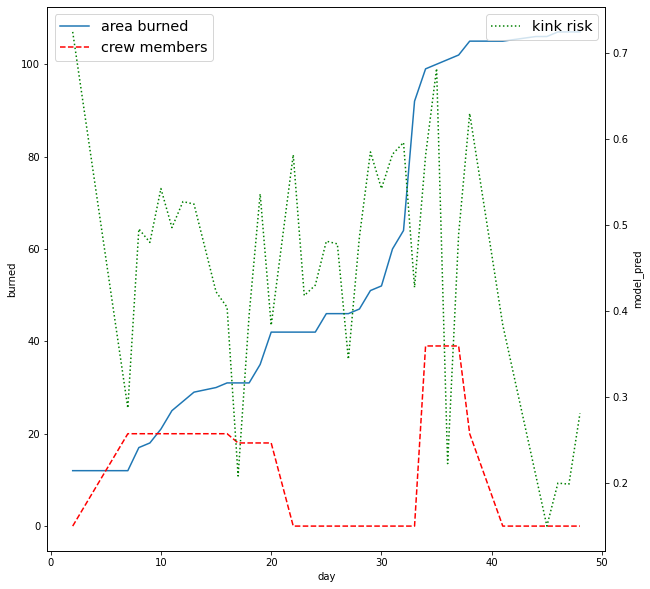

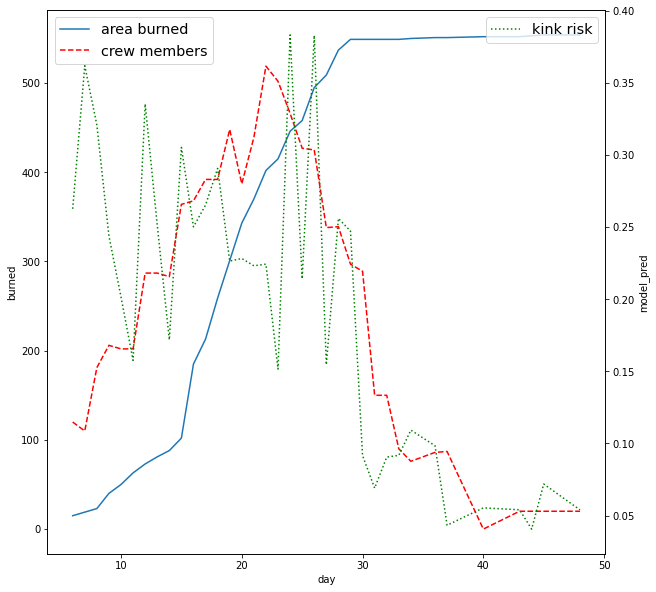

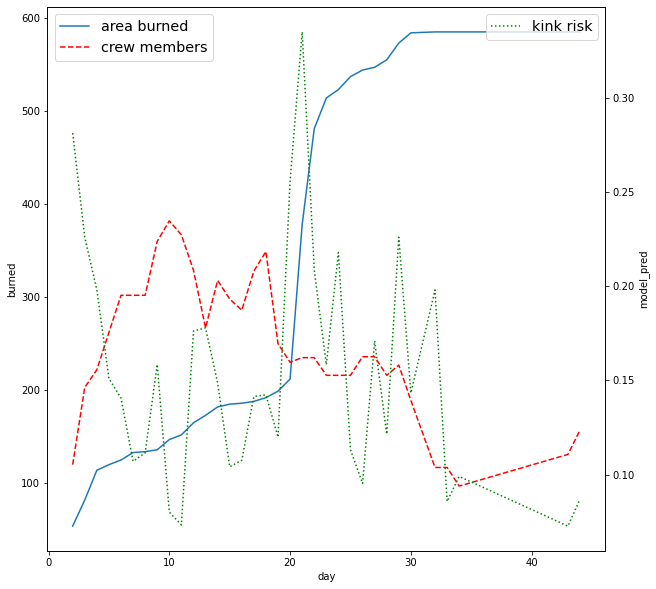

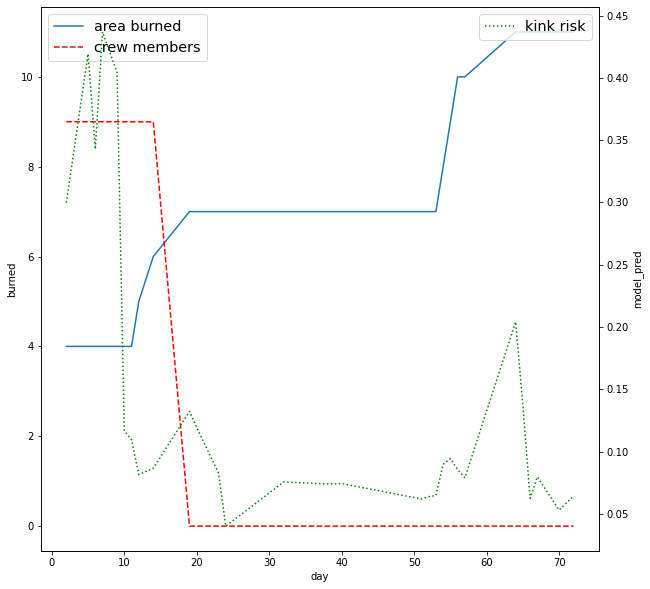

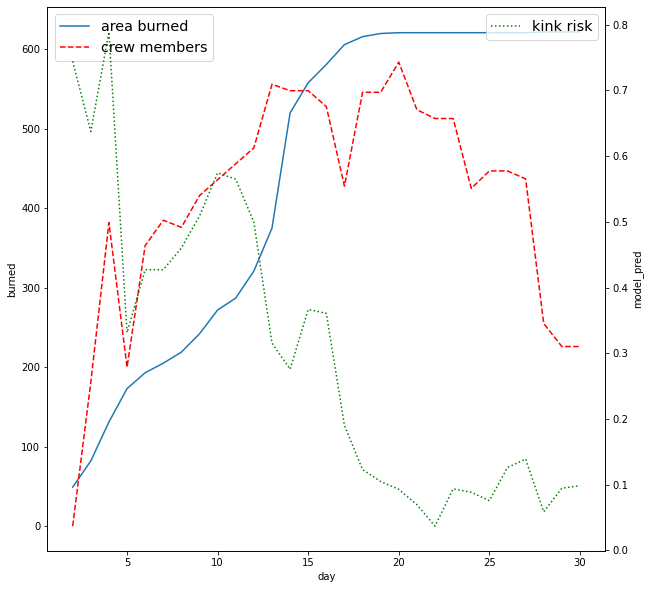

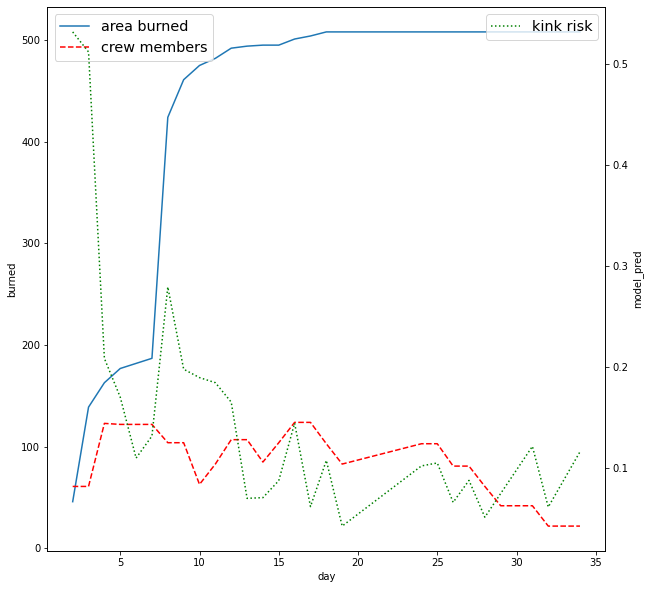

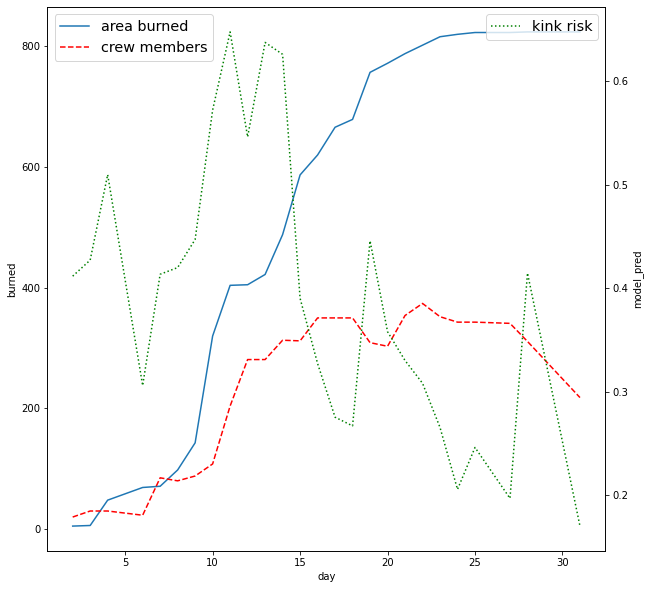

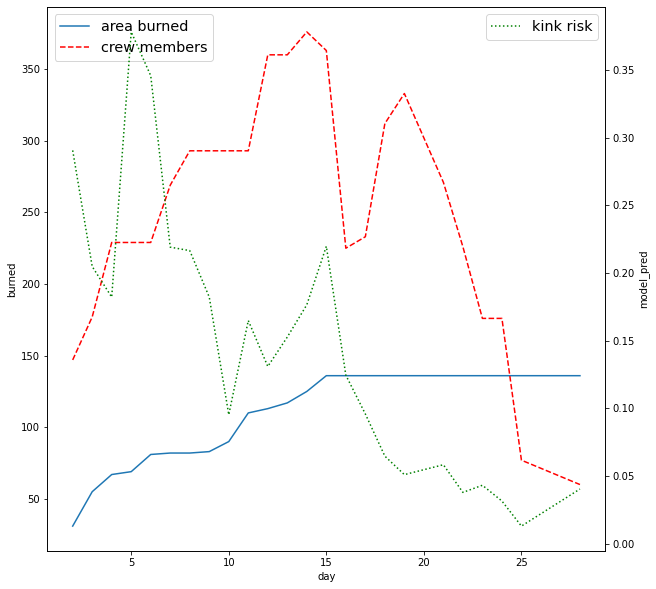

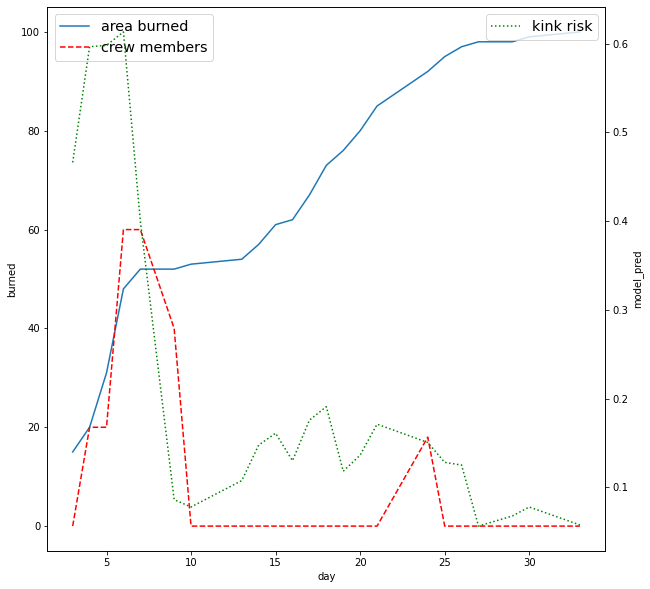

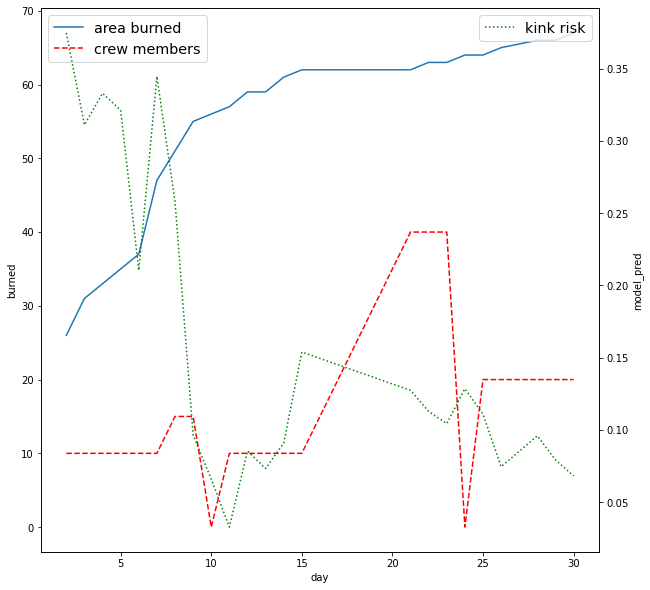

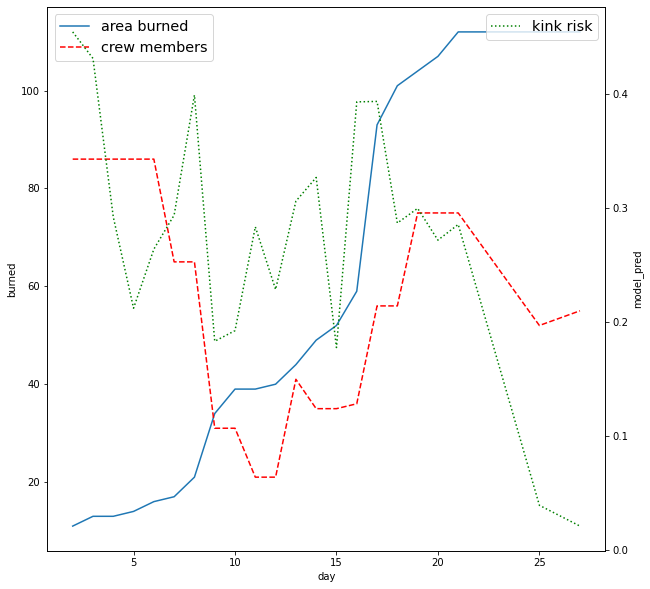

<Figure size 720x720 with 0 Axes>

In [118]:
for inc in longest_fires:
    inc_df = df[df['inc_id'] == inc]
    plt.rcParams['figure.figsize'] = (10, 10)
    sns.lineplot(data=inc_df, x='day', y='burned', label='area burned') 
    sns.lineplot(data=inc_df, x='day', y='crew_members', linestyle='dashed', color='red', label='crew members')
    plt.legend(fontsize='x-large', title_fontsize='40', loc=2)
    ax2 = plt.twinx()
    sns.lineplot(data=inc_df, x='day', y='model_pred', linestyle='dotted', color='green', ax=ax2, label='kink risk')
    plt.legend(fontsize='x-large', title_fontsize='40', loc=1)
    plt.show()
    plt.clf()


In [1119]:
plt.rcParams['figure.figsize'] = (10, 10)

In [1120]:
num_bins = 30

ordered_incs = df.groupby('inc_id', as_index=False).agg({'day' : max}).sort_values('day', ascending=False)['inc_id']
bins = np.array_split(np.asarray(ordered_incs), num_bins)

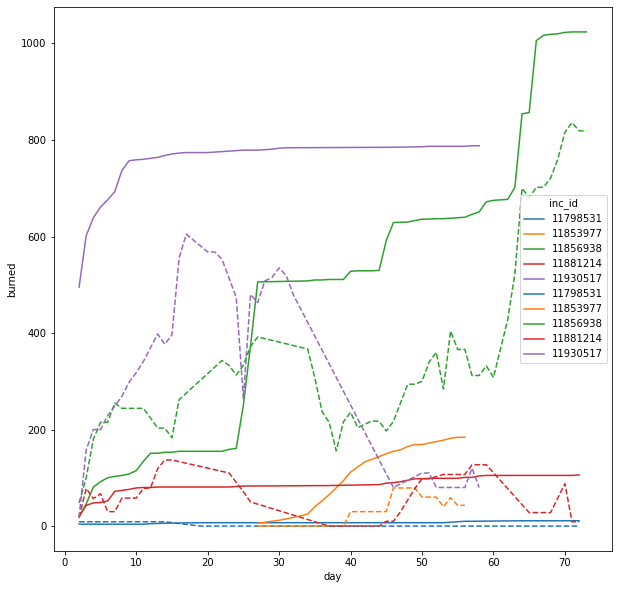

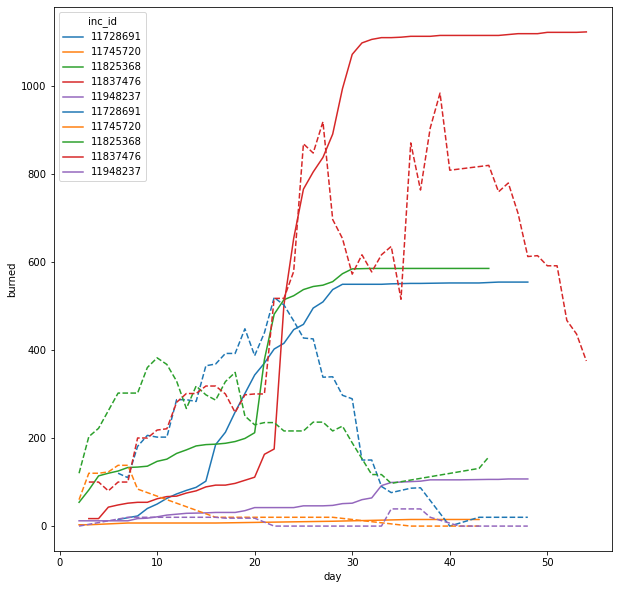

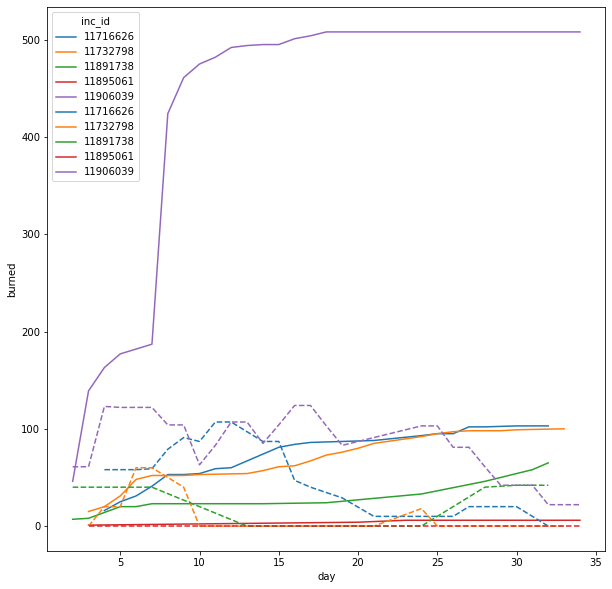

In [1121]:
for i in range(3):
    df_small = df[df['inc_id'].isin(bins[i])].copy()
    df_small['inc_id'] = df_small['inc_id'].astype(int).astype(str)
    sns.lineplot(data=df_small, x='day', y='burned', hue='inc_id')
    sns.lineplot(data=df_small, x='day', y='crew_members', hue='inc_id', linestyle='--')
    plt.show()

In [1247]:
for col in cols:
    df[f'log_{col}'] = np.log(1+df[col])

C:\Users\mit\anaconda3\envs\fire\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [1248]:
df.columns

Index(['inc_id', 'on_fire', 'on_fire_back_1', 'on_fire_back_2', 'day',
       'pct_contained', 'temp', 'humid', 'wind', 'tree_frac', 'tree_density',
       'shrub_frac', 'shrub_density', 'herb_frac', 'herb_density',
       'water_frac', 'slope', 'crew_members', 'dozers', 'engines',
       'helicopters', 'next_on_fire', 'burned', 'new_burned',
       'new_burned_plus_7', 'kink_next_7', 'log_inc_id', 'log_on_fire',
       'log_on_fire_back_1', 'log_on_fire_back_2', 'log_day',
       'log_pct_contained', 'log_temp', 'log_humid', 'log_wind',
       'log_tree_frac', 'log_tree_density', 'log_shrub_frac',
       'log_shrub_density', 'log_herb_frac', 'log_herb_density',
       'log_water_frac', 'log_slope', 'log_crew_members', 'log_dozers',
       'log_engines', 'log_helicopters', 'log_next_on_fire', 'log_burned',
       'log_new_burned', 'log_new_burned_plus_7', 'log_kink_next_7'],
      dtype='object')

In [1249]:
df

,inc_id,on_fire,on_fire_back_1,on_fire_back_2,day,pct_contained,temp,humid,wind,tree_frac,...,log_slope,log_crew_members,log_dozers,log_engines,log_helicopters,log_next_on_fire,log_burned,log_new_burned,log_new_burned_plus_7,log_kink_next_7
0,11691297.0,2.0,1.0,0.0,2.0,40.0,20.265983,0.013972,1.568414,1.00,...,0.405465,0.000000,0.000000,1.098612,1.098612,1.609438,1.098612,1.386294,3.135494,0.0
1,11691297.0,15.0,4.0,2.0,4.0,70.0,21.942244,0.014954,0.938979,1.00,...,0.470004,0.000000,0.000000,1.098612,1.098612,0.000000,2.944439,0.000000,1.945910,0.0
2,11697391.0,2.0,0.0,3.0,4.0,50.0,6.034494,0.002949,2.728190,0.50,...,2.970414,0.000000,0.000000,2.079442,0.693147,0.000000,1.609438,0.000000,0.000000,0.0
3,11700201.0,4.0,0.0,0.0,2.0,70.0,14.352520,0.005316,2.412046,1.00,...,0.223144,0.000000,0.000000,0.000000,0.693147,0.000000,1.609438,0.000000,0.000000,0.0
4,11706093.0,2.0,4.0,0.0,2.0,75.0,4.068012,0.003789,3.586409,0.50,...,3.135494,3.044522,1.098612,2.197225,1.098612,0.000000,1.945910,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1169,11972557.0,17.0,26.0,0.0,6.0,30.0,9.348621,0.001724,3.211690,0.00,...,2.742736,5.746203,2.397895,5.159055,2.833213,0.000000,3.663562,0.000000,0.000000,0.0
1170,11973856.0,10.0,1.0,0.0,2.0,50.0,11.552968,0.004180,4.500221,0.30,...,2.867899,0.000000,0.000000,1.386294,1.098612,0.000000,2.397895,0.000000,0.000000,0.0
1171,11975102.0,4.0,0.0,0.0,2.0,0.0,7.699664,0.003295,2.802063,0.75,...,3.258097,0.000000,0.000000,0.000000,1.098612,0.693147,1.609438,0.000000,0.000000,0.0
1172,11975102.0,1.0,1.0,4.0,4.0,20.0,13.039293,0.003281,4.929900,1.00,...,3.135494,0.000000,0.000000,0.000000,0.693147,0.693147,1.609438,0.000000,0.000000,0.0


## Regression models

In [14]:
def get_regression_formula(covariates, logs, target='kink_next_7'):
    
    new_cols = [col if col not in logs else 'log_' + col for col in covariates]
    features = ' + '.join(new_cols)

    if target in logs:
        target = 'log_' + target
    formula = target + ' ~ '  + features
    
    return formula

In [63]:
def analysis(cols_to_keep, logs):
    
    formula = get_regression_formula(cols_to_keep, logs)
    print(formula)
    print()

    model = smf.logit(formula=formula, data=df)
    result = model.fit(cov_type='HC3')
    display(result.summary())


    target = formula.split('~')[0].replace(' ', '')
    covs = formula.split('~')[1].replace(' ', '').split('+')

    y = df[target]
    X = df[covs]
    auc = roc_auc_score(y, result.predict(X))
    print(f'In-sample AUC: {auc}')

    # now out of sample
    trials = 250
    aucs = []
    for trial in range(trials):

        frac = 0
        while frac < 0.7 or frac > 0.8:
            train_ids, test_ids = train_test_split(df['inc_id'].drop_duplicates())
            frac = df['inc_id'].isin(train_ids).mean()

        model = smf.logit(formula=formula, data=df[df['inc_id'].isin(train_ids)])
        result = model.fit(cov_type='HC3', disp=0)

        target = formula.split('~')[0].replace(' ', '')
        covs = formula.split('~')[1].replace(' ', '').split('+')

        y = df[df['inc_id'].isin(test_ids)][target]
        X = df[df['inc_id'].isin(test_ids)][covs]
        aucs.append(roc_auc_score(y, result.predict(X)))
    print(f'Mean (cross-validated) out-of-sample AUC: {np.mean(np.asarray(aucs))}')
    plt.hist(aucs)
    
    plt.show()
    
    return

In [1252]:
logs = []
cols_to_keep = ['on_fire', 'crew_members']
formula = get_regression_formula(cols_to_keep, logs)
formula

'kink_next_7 ~ on_fire + crew_members'

kink_next_7 ~ on_fire + crew_members

Optimization terminated successfully.
         Current function value: 0.527382
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            kink_next_7   No. Observations:                 1174
Model:                          Logit   Df Residuals:                     1171
Method:                           MLE   Df Model:                            2
Date:                Mon, 06 Jun 2022   Pseudo R-squ.:                0.002599
Time:                        09:56:16   Log-Likelihood:                -619.15
converged:                       True   LL-Null:                       -620.76
Covariance Type:                  HC3   LLR p-value:                    0.1992
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -1.3091      0.085    -15.456      0.000      -1.475      -1.143
on_fire          0.0021      0.001      1.991      0.046    3.25e-05       0.004
crew_members    -0.0002      0.001     -0.245      0.806      -0.002       0.001
================================================================================
"""

In-sample AUC: 0.6294773607136845
Mean (cross-validated) out-of-sample AUC: 0.5607857380830346


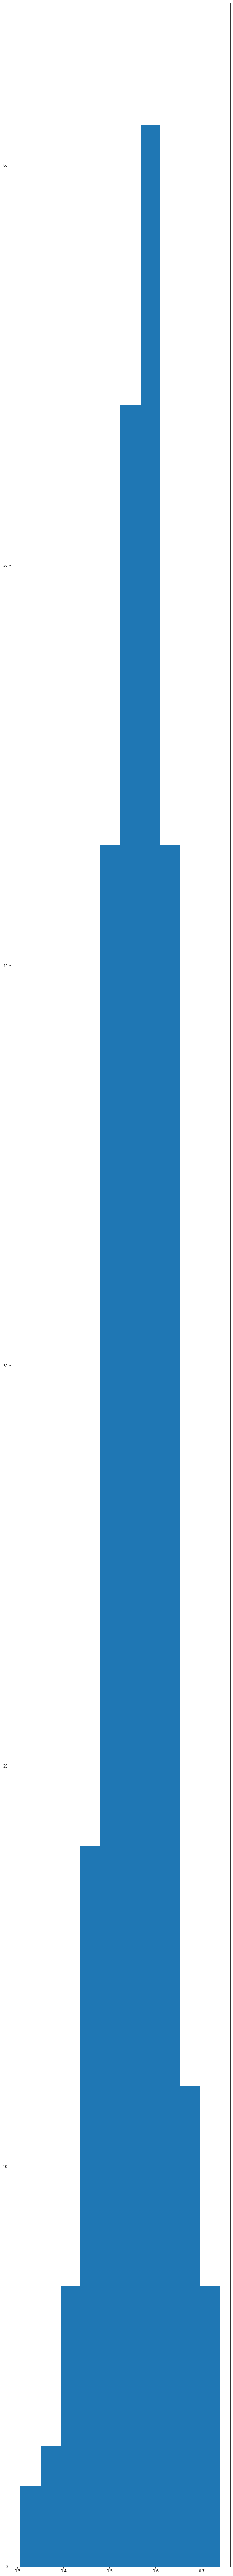

In [1253]:
analysis(cols_to_keep, logs)

kink_next_7 ~ log_on_fire + log_on_fire_back_1 + log_on_fire_back_2 + log_pct_contained + temp + humid + wind + log_tree_frac + log_tree_density + log_shrub_frac + log_shrub_density + log_herb_frac + log_herb_density + log_water_frac + log_slope + log_crew_members + log_dozers + log_engines + log_helicopters

Optimization terminated successfully.
         Current function value: 0.455823
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            kink_next_7   No. Observations:                 1174
Model:                          Logit   Df Residuals:                     1154
Method:                           MLE   Df Model:                           19
Date:                Tue, 06 Sep 2022   Pseudo R-squ.:                  0.1379
Time:                        10:36:44   Log-Likelihood:                -535.14
converged:                       True   LL-Null:                       -620.76
Covariance Type:                  HC3   LLR p-value:                 1.620e-26
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -3.7949      1.539     -2.465      0.014      -6.812      -0.778
log_on_fire            0.4628      0.132      3.503      0.000       0.204       0.722
log_on_fire_back_1    -0.1078      0.108     -1.000      0.317      -0.319       0.103
log_on_fire_back_2     0.0477      0.076      0.624      0.533      -0.102       0.197
log_pct_contained     -0.4745      0.054     -8.821      0.000      -0.580      -0.369
temp                   0.0147      0.016      0.911      0.362      -0.017       0.046
humid                -67.4153     44.458     -1.516      0.129    -154.552      19.721
wind                   0.1173      0.062      1.891      0.059      -0.004       0.239
log_tree_frac          5.2063      2.399      2.170      0.030       0.505       9.908
log_tree_density      -0.0808      0.182     -0.444      0.657      -0.438       0.276
log_shrub_frac         4.8626      2.113      2.302      0.021       0.722       9.004
log_shrub_density     -0.0306      0.077     -0.396      0.692      -0.182       0.121
log_herb_frac          4.2276      2.505      1.687      0.092      -0.683       9.138
log_herb_density      -0.2545      0.084     -3.033      0.002      -0.419      -0.090
log_water_frac        -0.9407      5.572     -0.169      0.866     -11.861       9.980
log_slope             -0.3185      0.201     -1.585      0.113      -0.712       0.075
log_crew_members      -0.1396      0.070     -1.983      0.047      -0.278      -0.002
log_dozers            -0.3282      0.120     -2.734      0.006      -0.563      -0.093
log_engines            0.3522      0.114      3.093      0.002       0.129       0.575
log_helicopters        0.1584      0.118      1.338      0.181      -0.074       0.391
======================================================================================
"""

In-sample AUC: 0.7582561858273018
Mean (cross-validated) out-of-sample AUC: 0.6845717655248779


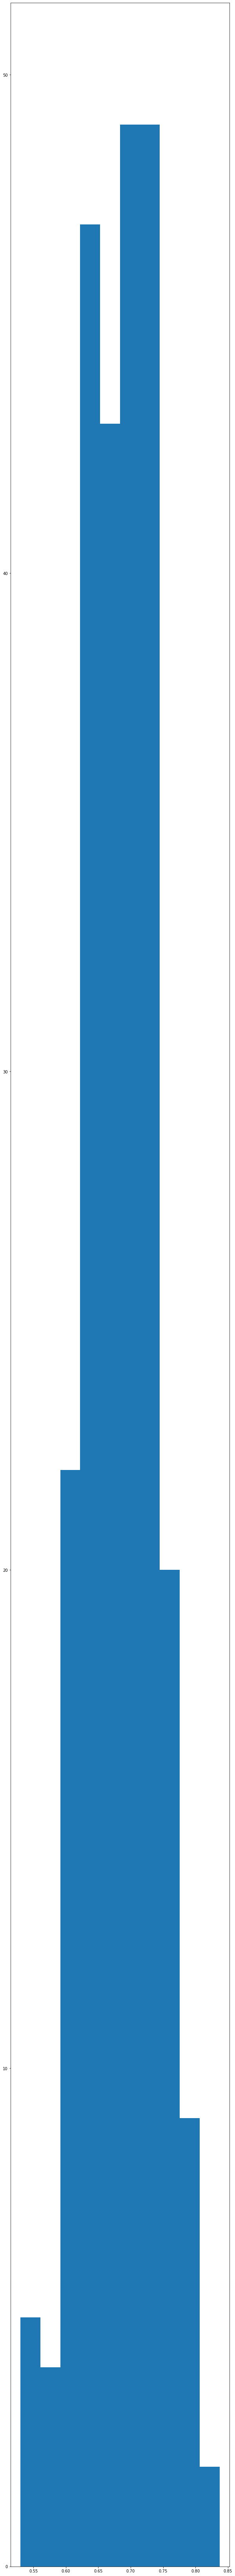

In [64]:
cols_to_keep = cols[1:-5] 
cols_to_keep = [col for col in cols_to_keep if 'day' not in col]
# cols_to_keep = [col for col in cols_to_keep if 'on_fire' not in col]
logs = [col for col in cols_to_keep if col not in ['temp', 'humid', 'wind']]

analysis(cols_to_keep, logs)

kink_next_7 ~ log_on_fire + log_on_fire_back_1 + log_on_fire_back_2 + log_pct_contained + temp + humid + wind + log_tree_frac + log_tree_density + log_shrub_frac + log_shrub_density + log_herb_frac + log_herb_density + log_water_frac + log_slope

Optimization terminated successfully.
         Current function value: 0.461511
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            kink_next_7   No. Observations:                 1174
Model:                          Logit   Df Residuals:                     1158
Method:                           MLE   Df Model:                           15
Date:                Thu, 02 Jun 2022   Pseudo R-squ.:                  0.1272
Time:                        15:19:33   Log-Likelihood:                -541.81
converged:                       True   LL-Null:                       -620.76
Covariance Type:                  HC3   LLR p-value:                 6.482e-26
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -4.0901      1.514     -2.702      0.007      -7.057      -1.123
log_on_fire            0.4811      0.129      3.736      0.000       0.229       0.733
log_on_fire_back_1    -0.1024      0.106     -0.971      0.332      -0.309       0.104
log_on_fire_back_2     0.0536      0.075      0.719      0.472      -0.093       0.200
log_pct_contained     -0.4414      0.050     -8.852      0.000      -0.539      -0.344
temp                   0.0105      0.016      0.664      0.506      -0.021       0.042
humid                -78.9787     43.328     -1.823      0.068    -163.901       5.943
wind                   0.1453      0.060      2.432      0.015       0.028       0.262
log_tree_frac          5.2486      2.305      2.277      0.023       0.730       9.767
log_tree_density      -0.1096      0.178     -0.617      0.537      -0.458       0.238
log_shrub_frac         5.0824      2.037      2.495      0.013       1.090       9.075
log_shrub_density     -0.0318      0.076     -0.420      0.674      -0.180       0.117
log_herb_frac          3.7786      2.483      1.522      0.128      -1.087       8.645
log_herb_density      -0.2370      0.084     -2.829      0.005      -0.401      -0.073
log_water_frac        -1.2739      5.489     -0.232      0.816     -12.031       9.483
log_slope             -0.1923      0.203     -0.946      0.344      -0.591       0.206
======================================================================================
"""

In-sample AUC: 0.7484977276552768
Mean (cross-validated) out-of-sample AUC: 0.6977248800552696


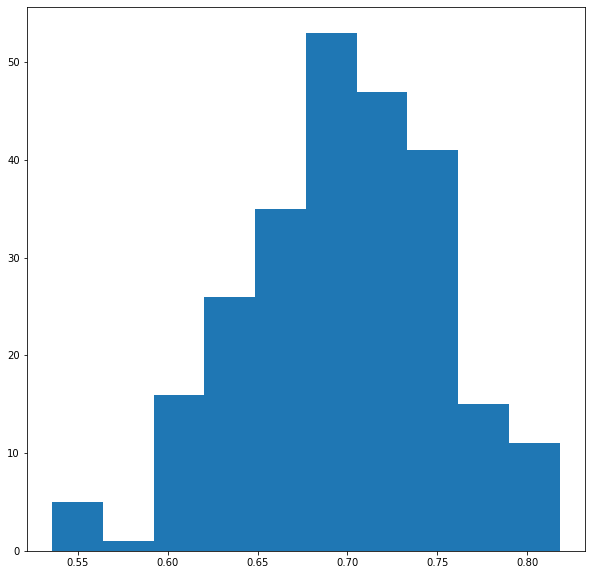

In [1229]:
cols_to_keep = cols[1:-9] 
cols_to_keep = [col for col in cols_to_keep if 'day' not in col]
# cols_to_keep = [col for col in cols_to_keep if 'on_fire' not in col]
logs = [col for col in cols_to_keep if col not in ['temp', 'humid', 'wind']]

analysis(cols_to_keep, logs)

kink_next_7 ~ log_on_fire + log_pct_contained + wind + temp

Optimization terminated successfully.
         Current function value: 0.474955
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            kink_next_7   No. Observations:                 1174
Model:                          Logit   Df Residuals:                     1169
Method:                           MLE   Df Model:                            4
Date:                Mon, 06 Jun 2022   Pseudo R-squ.:                  0.1018
Time:                        09:56:35   Log-Likelihood:                -557.60
converged:                       True   LL-Null:                       -620.76
Covariance Type:                  HC3   LLR p-value:                 2.377e-26
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -1.6373      0.290     -5.640      0.000      -2.206      -1.068
log_on_fire           0.2784      0.057      4.863      0.000       0.166       0.391
log_pct_contained    -0.4207      0.046     -9.224      0.000      -0.510      -0.331
wind                  0.1576      0.053      2.993      0.003       0.054       0.261
temp                  0.0067      0.012      0.540      0.590      -0.018       0.031
=====================================================================================
"""

In-sample AUC: 0.729700387140212
Mean (cross-validated) out-of-sample AUC: 0.7102695004542632


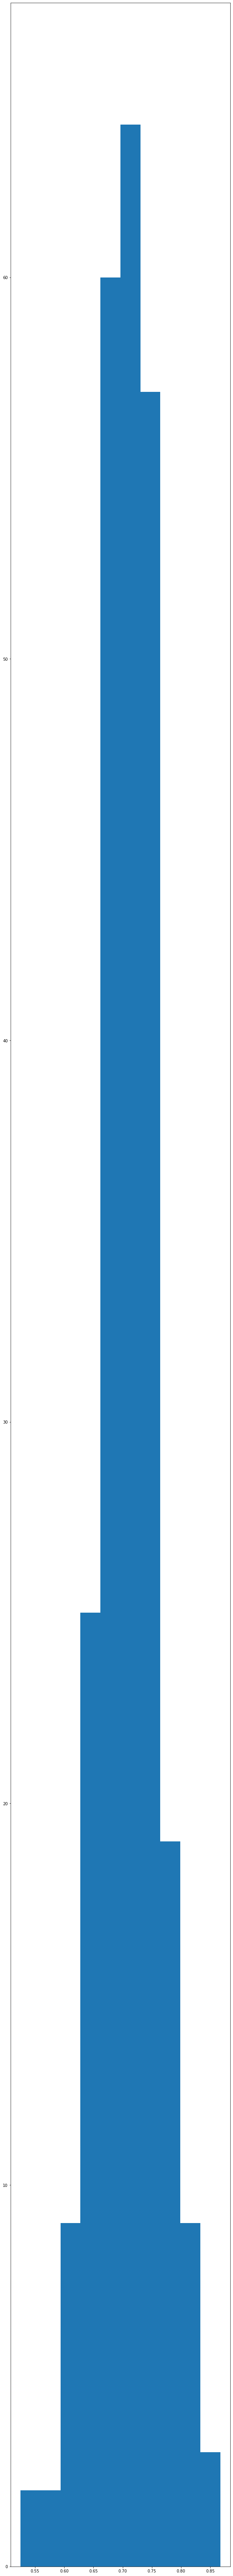

In [1255]:
logs = ['on_fire', 'pct_contained']
cols_to_keep = ['on_fire', 'pct_contained', 'wind', 'temp']
analysis(cols_to_keep, logs)

### Regress on yesterday fire + crew members ###

In [887]:
logs = []
cols_to_keep = ['on_fire', 'crew_members']
formula = get_regression_formula(cols_to_keep, logs)
formula

'new_burned_plus_7 ~ on_fire + crew_members'

In [888]:
model = smf.ols(formula=formula, data=df)
result = model.fit(cov_type='HC3')
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      new_burned_plus_7   R-squared:                       0.132
Model:                            OLS   Adj. R-squared:                  0.130
Method:                 Least Squares   F-statistic:                     46.63
Date:                Fri, 27 May 2022   Prob (F-statistic):           3.28e-20
Time:                        08:08:00   Log-Likelihood:                -7030.7
No. Observations:                1174   AIC:                         1.407e+04
Df Residuals:                    1171   BIC:                         1.408e+04
Df Model:                           2                                         
Covariance Type:                  HC3                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       19.3817      2.805      6.909      0.000      13.884      24.880
on_fire          0.6083      0.075      8.104      0.000       0.461       0.755
crew_members     0.0481      0.014      3.324      0.001       0.020       0.077
==============================================================================
Omnibus:                      992.414   Durbin-Watson:                   0.320
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            21168.958
Skew:                           3.950   Prob(JB):                         0.00
Kurtosis:                      22.244   Cond. No.                         350.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

### Same but with logs ###

In [929]:
logs = ['new_burned_plus_7', 'on_fire', 'crew_members']
cols_to_keep = ['on_fire']
formula = get_regression_formula(cols_to_keep, logs)
formula

'log_new_burned_plus_7 ~ log_on_fire'

In [930]:
model = smf.ols(formula=formula, data=df)
result = model.fit(cov_type='HC3')
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     log_new_burned_plus_7   R-squared:                       0.382
Model:                               OLS   Adj. R-squared:                  0.382
Method:                    Least Squares   F-statistic:                     932.0
Date:                   Fri, 27 May 2022   Prob (F-statistic):          4.28e-151
Time:                           11:38:18   Log-Likelihood:                -2074.3
No. Observations:                   1174   AIC:                             4153.
Df Residuals:                       1172   BIC:                             4163.
Df Model:                              1                                         
Covariance Type:                     HC3                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.0486      0.079     -0.614      0.539      -0.204       0.107
log_on_fire     0.8971      0.029     30.528      0.000       0.839       0.955
==============================================================================
Omnibus:                       29.478   Durbin-Watson:                   0.762
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.193
Skew:                           0.399   Prob(JB):                     1.68e-07
Kurtosis:                       3.048   Cond. No.                         6.90
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

### Include all features, log all fire sizes ##

In [900]:
logs = ['new_burned_plus_7', 'on_fire', 'on_fire_back_1', 'on_fire_back_2']
cols_to_keep = cols[1:-4]
formula = get_regression_formula(cols_to_keep, logs)
formula

'log_new_burned_plus_7 ~ log_on_fire + log_on_fire_back_1 + log_on_fire_back_2 + day + pct_contained + temp + humid + wind + tree_frac + tree_density + shrub_frac + shrub_density + herb_frac + herb_density + water_frac + slope + crew_members + dozers + engines + helicopters'

In [901]:
model = smf.ols(formula=formula, data=df)
result = model.fit(cov_type='HC3')
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     log_new_burned_plus_7   R-squared:                       0.461
Model:                               OLS   Adj. R-squared:                  0.452
Method:                    Least Squares   F-statistic:                     70.31
Date:                   Fri, 27 May 2022   Prob (F-statistic):          2.28e-183
Time:                           08:10:10   Log-Likelihood:                -1994.3
No. Observations:                   1174   AIC:                             4031.
Df Residuals:                       1153   BIC:                             4137.
Df Model:                             20                                         
Covariance Type:                     HC3                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.1231      0.587     -0.210      0.834      -1.274       1.028
log_on_fire            0.8614      0.065     13.350      0.000       0.735       0.988
log_on_fire_back_1    -0.0579      0.054     -1.070      0.285      -0.164       0.048
log_on_fire_back_2     0.0212      0.041      0.520      0.603      -0.059       0.101
day                    0.0027      0.003      0.808      0.419      -0.004       0.009
pct_contained         -0.0155      0.002     -9.124      0.000      -0.019      -0.012
temp                   0.0245      0.010      2.434      0.015       0.005       0.044
humid                -26.2892     22.030     -1.193      0.233     -69.467      16.888
wind                  -0.0033      0.039     -0.084      0.933      -0.080       0.074
tree_frac              0.8538      0.524      1.630      0.103      -0.173       1.881
tree_density          -0.0067      0.004     -1.874      0.061      -0.014       0.000
shrub_frac             0.4993      0.563      0.887      0.375      -0.604       1.602
shrub_density         -0.0023      0.003     -0.699      0.485      -0.009       0.004
herb_frac             -0.5267      0.648     -0.813      0.416      -1.797       0.743
herb_density          -0.0033      0.003     -1.042      0.297      -0.010       0.003
water_frac             3.4701      2.593      1.338      0.181      -1.611       8.552
slope                  0.0015      0.007      0.203      0.839      -0.013       0.016
crew_members          -0.0004      0.000     -1.186      0.236      -0.001       0.000
dozers                -0.0362      0.008     -4.828      0.000      -0.051      -0.022
engines                0.0040      0.001      2.722      0.006       0.001       0.007
helicopters            0.0439      0.014      3.158      0.002       0.017       0.071
==============================================================================
Omnibus:                       24.343   Durbin-Watson:                   0.792
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.359
Skew:                           0.344   Prob(JB):                     3.11e-06
Kurtosis:                       3.213   Cond. No.                     1.51e+05
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
[2] The condition number is large, 1.51e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Log everything

In [910]:
cols_to_keep = cols[1:-4] 
cols_to_keep = [col for col in cols_to_keep if 'day' not in col]
# cols_to_keep = [col for col in cols_to_keep if 'on_fire' not in col]
logs = ['new_burned_plus_7'] + cols_to_keep
formula = get_regression_formula(cols_to_keep, logs)
formula

'log_new_burned_plus_7 ~ log_on_fire + log_on_fire_back_1 + log_on_fire_back_2 + log_pct_contained + log_temp + log_humid + log_wind + log_tree_frac + log_tree_density + log_shrub_frac + log_shrub_density + log_herb_frac + log_herb_density + log_water_frac + log_slope + log_crew_members + log_dozers + log_engines + log_helicopters'

In [911]:
model = smf.ols(formula=formula, data=df)
result = model.fit(cov_type='HC3')
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     log_new_burned_plus_7   R-squared:                       0.446
Model:                               OLS   Adj. R-squared:                  0.437
Method:                    Least Squares   F-statistic:                     71.79
Date:                   Fri, 27 May 2022   Prob (F-statistic):          2.86e-179
Time:                           08:13:20   Log-Likelihood:                -1978.5
No. Observations:                   1158   AIC:                             3997.
Df Residuals:                       1138   BIC:                             4098.
Df Model:                             19                                         
Covariance Type:                     HC3                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -1.5048      0.731     -2.060      0.039      -2.937      -0.073
log_on_fire            0.9138      0.064     14.221      0.000       0.788       1.040
log_on_fire_back_1    -0.0454      0.055     -0.829      0.407      -0.153       0.062
log_on_fire_back_2     0.0263      0.041      0.648      0.517      -0.053       0.106
log_pct_contained     -0.2266      0.027     -8.354      0.000      -0.280      -0.173
log_temp               0.0775      0.099      0.779      0.436      -0.117       0.272
log_humid             -0.9139     21.897     -0.042      0.967     -43.832      42.004
log_wind               0.3139      0.170      1.843      0.065      -0.020       0.648
log_tree_frac          2.8824      0.964      2.990      0.003       0.993       4.772
log_tree_density      -0.1431      0.078     -1.824      0.068      -0.297       0.011
log_shrub_frac         2.2669      0.908      2.496      0.013       0.487       4.047
log_shrub_density     -0.0621      0.043     -1.439      0.150      -0.147       0.022
log_herb_frac          0.8358      0.962      0.869      0.385      -1.050       2.722
log_herb_density      -0.0755      0.042     -1.802      0.072      -0.158       0.007
log_water_frac         4.8080      2.841      1.692      0.091      -0.761      10.377
log_slope              0.0200      0.106      0.190      0.849      -0.187       0.227
log_crew_members      -0.1027      0.039     -2.622      0.009      -0.179      -0.026
log_dozers            -0.1247      0.066     -1.892      0.058      -0.254       0.004
log_engines            0.1831      0.059      3.091      0.002       0.067       0.299
log_helicopters        0.1782      0.068      2.604      0.009       0.044       0.312
==============================================================================
Omnibus:                       32.773   Durbin-Watson:                   0.756
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               34.839
Skew:                           0.412   Prob(JB):                     2.72e-08
Kurtosis:                       3.210   Cond. No.                     5.17e+03
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
[2] The condition number is large, 5.17e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [917]:
cols_to_keep = cols[1:-8] 
cols_to_keep = [col for col in cols_to_keep if 'day' not in col]
# cols_to_keep = [col for col in cols_to_keep if 'on_fire' not in col]
logs = ['crew_members'] + cols_to_keep
formula = get_regression_formula(cols_to_keep, logs, target='crew_members')
formula

'log_crew_members ~ log_on_fire + log_on_fire_back_1 + log_on_fire_back_2 + log_pct_contained + log_temp + log_humid + log_wind + log_tree_frac + log_tree_density + log_shrub_frac + log_shrub_density + log_herb_frac + log_herb_density + log_water_frac + log_slope'

In [918]:
model = smf.ols(formula=formula, data=df)
result = model.fit(cov_type='HC3')
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       log_crew_members   R-squared:                       0.278
Model:                            OLS   Adj. R-squared:                  0.268
Method:                 Least Squares   F-statistic:                     34.53
Date:                Fri, 27 May 2022   Prob (F-statistic):           4.39e-82
Time:                        10:05:56   Log-Likelihood:                -2191.9
No. Observations:                1158   AIC:                             4416.
Df Residuals:                    1142   BIC:                             4497.
Df Model:                          15                                         
Covariance Type:                  HC3                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.4336      0.967      0.448      0.654      -1.462       2.329
log_on_fire            0.1391      0.069      2.009      0.045       0.003       0.275
log_on_fire_back_1     0.2370      0.060      3.935      0.000       0.119       0.355
log_on_fire_back_2     0.2323      0.045      5.139      0.000       0.144       0.321
log_pct_contained      0.2240      0.036      6.224      0.000       0.153       0.295
log_temp               0.4016      0.098      4.100      0.000       0.210       0.594
log_humid             63.2497     30.217      2.093      0.036       4.026     122.473
log_wind               0.3145      0.204      1.545      0.122      -0.085       0.714
log_tree_frac         -2.7531      1.220     -2.257      0.024      -5.143      -0.363
log_tree_density       0.4902      0.108      4.555      0.000       0.279       0.701
log_shrub_frac        -0.6659      1.039     -0.641      0.522      -2.703       1.371
log_shrub_density     -0.0256      0.048     -0.530      0.596      -0.120       0.069
log_herb_frac         -0.5840      1.186     -0.492      0.622      -2.909       1.741
log_herb_density      -0.0691      0.048     -1.441      0.150      -0.163       0.025
log_water_frac         1.9220      1.917      1.003      0.316      -1.835       5.679
log_slope              0.0260      0.186      0.140      0.889      -0.338       0.390
==============================================================================
Omnibus:                      170.941   Durbin-Watson:                   0.587
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              251.735
Skew:                          -1.055   Prob(JB):                     2.17e-55
Kurtosis:                       3.875   Cond. No.                     4.16e+03
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
[2] The condition number is large, 4.16e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Scratch

In [657]:
ids = df['inc_id'].unique()
np.random.shuffle(ids)

In [658]:
count = 0
train_ids = []
for inc_id in ids:
    if count < 0.7 * len(df):
        train_ids += [inc_id]
        count += len(df[df['inc_id'] == inc_id])
test_ids = [i for i in ids if i not in train_ids]

In [659]:
df_train = df[df['inc_id'].isin(train_ids)].copy()
df_test = df[df['inc_id'].isin(test_ids)].copy()

In [665]:
X = df_train.to_numpy().astype(float)
X[:, 1:5] = np.log(1 + X[:, 1:5])
X[:, -5:-1] = np.log(1 + X[:, -5:-1])
y = X[:, -1].astype(float)
y = np.log(1 + y)
X = X[:, 1:-4]

In [666]:
y.shape

(828,)

In [667]:
beta, _, _, _ = np.linalg.lstsq(X, y, rcond=None)

In [668]:
dict(zip(cols[1:-1], beta))

{'on_fire': 0.8952825704707907,
 'on_fire_back_1': -0.10161923599728424,
 'on_fire_back_2': 0.07655219363367277,
 'pct_contained': -0.11380310132452881,
 'temp': 0.013629886602427296,
 'humid': -72.90892080463404,
 'wind': -0.038389048739287016,
 'tree_frac': 0.4953598823831116,
 'tree_density': -0.003988895771176337,
 'shrub_frac': -0.10578330453055944,
 'shrub_density': 0.004081177127531768,
 'herb_frac': -0.21621147409975996,
 'herb_density': -0.004404308767020075,
 'water_frac': 1.747486014401449,
 'slope': 0.003817357892438193,
 'crew_members': 0.06912246112908454}

In [607]:
X_test = df_test.to_numpy().astype(float)
X_test[:, 1:4] = np.log(1 + X_test[:, 1:4])
y_test = X_test[:, -1].astype(float)
y_test = np.log(1 + y_test)
X_test = X_test[:, 1:-4]

In [608]:
np.mean(((X_test @ beta) - y_test)**2)

0.8504165452255045

In [609]:
np.mean(((X @ beta) - y)**2)

0.9077419184026199

In [610]:
beta

array([ 9.26732146e-01, -1.13313573e-01,  7.92530220e-02,  4.41634539e-03,
       -6.72598331e+01, -9.35284471e-02,  6.21219739e-01, -2.24531235e-03,
        1.19814588e-01,  6.21628522e-03,  1.10284186e-01, -5.17492266e-03,
        7.06863197e+00, -4.09110961e-03,  3.32820425e-04])

(array([1.027e+03, 7.800e+01, 3.100e+01, 1.500e+01, 8.000e+00, 8.000e+00,
        1.000e+00, 2.000e+00, 3.000e+00, 1.000e+00]),
 array([0.0, 49.8, 99.6, 149.39999999999998, 199.2, 249.0,
        298.79999999999995, 348.59999999999997, 398.4, 448.2, 498.0],
       dtype=object),
 <BarContainer object of 10 artists>)

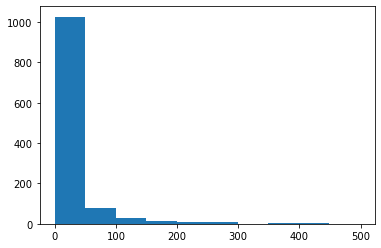

In [482]:
plt.hist(y)

(array([218., 205., 162., 177., 147., 119.,  66.,  42.,  26.,  12.]),
 array([0.69314718, 1.24609009, 1.799033  , 2.35197591, 2.90491882,
        3.45786172, 4.01080463, 4.56374754, 5.11669045, 5.66963336,
        6.22257627]),
 <BarContainer object of 10 artists>)

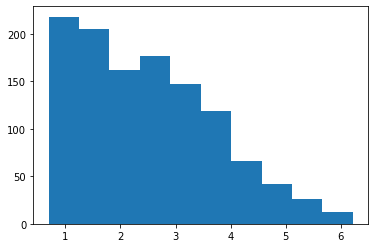

In [467]:
plt.hist(np.log((df['on_fire'] + 1.0).astype(float)))

In [446]:
len(to_add)

18

In [440]:
count, reports_count

(1392, 1143)

In [436]:
to_add

[3,
 1,
 0,
 2.943808377294958,
 0.003786693484086424,
 1.925399431880492,
 1.0,
 73.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0,
 1.0,
 1.0,
 0.0]

In [438]:
next_on_fire_count

0

In [432]:
weather

{'TMP:2 m': 2.943808377294958,
 'SPFH:2 m': 0.003786693484086424,
 'UGRD:10 m': 0.2579042310608733,
 'VGRD:10 m': 0.5159784986362029,
 'LTNG': 0.0,
 'PRATE': 0.0,
 'PRES:surface': 99238.7702173639,
 'wind': 1.925399431880492}

In [431]:
day_resources

,INC209RU_IDENTIFIER,INC209R_IDENTIFIER,RESTYP_IDENTIFIER,resource,RESOURCE_QUANTITY,RESOURCE_PERSONNEL
128242,11980938,11980926,9429928,Dozer,1.0,1
128243,11980939,11980926,9429934,"Engine, Type 6",1.0,2
128244,11980940,11980926,9429953,Overhead,NaN,0
128245,11980941,11980926,9429953,Overhead,NaN,6


In [430]:
count, reports_count

(1202, 1022)

In [358]:
report_date = dt.datetime.strptime(info_dict['start_day'], "%Y%m%d") + dt.timedelta(days=day)
report_date

datetime.datetime(2020, 10, 11, 0, 0)

In [361]:
report_id = reports_df[(reports_df['INC_IDENTIFIER'] == int(inc_id)) & (reports_df['report_date'] == report_date)]
report_id = report_id['INC209R_IDENTIFIER'].iloc[0]

In [362]:
report_id

11854145

In [366]:
day_resources = resources_df[resources_df['INC209R_IDENTIFIER'] == report_id].copy()

In [372]:
day_resources

,INC209RU_IDENTIFIER,INC209R_IDENTIFIER,RESTYP_IDENTIFIER,resource,RESOURCE_QUANTITY,RESOURCE_PERSONNEL
56549,11854152,11854145,9429934,"Engine, Type 6",2.0,6
56550,11854153,11854145,9429934,"Engine, Type 6",2.0,5
56551,11854154,11854145,9429939,"Crew, Type 2IA",2.0,30
56552,11854155,11854145,9429940,"Helicopter, Type 1",1.0,2
56553,11854156,11854145,9429942,"Helicopter, Type 3",1.0,3
56554,11854157,11854145,9429951,"Tender, Water (Tactical)",1.0,1
56555,11854158,11854145,9429953,Overhead,NaN,0
56556,11854159,11854145,9429953,Overhead,NaN,10


In [417]:
crew_members = day_resources[day_resources['resource'].apply(lambda x: 'CREW' in x.upper())]['RESOURCE_PERSONNEL'].sum()
dozers = day_resources[day_resources['resource'].apply(lambda x: 'DOZER' in x.upper())]['RESOURCE_QUANTITY'].sum()
engines = day_resources[day_resources['resource'].apply(lambda x: 'ENGINE' in x.upper())]['RESOURCE_QUANTITY'].sum()
helicopters = day_resources[day_resources['resource'].apply(lambda x: 'HELICOPTER' in x.upper())]['RESOURCE_QUANTITY'].sum()

In [383]:
crew_members, dozers, engines

(30, 0.0, 4.0)

In [274]:
on_fire_count, weather['TMP:2 m'], weather['wind'], weather['SPFH:2 m'], tree_frac, tree_density, shrub_frac, shrub_density, herb_frac, herb_density, water_frac

(2,
 9.194424895142332,
 2.177284053902048,
 0.006509858727693603,
 0.5,
 73.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.5)